# Descriptive Statistics and Plots

The purpose of this notebook is to explore some of our questions after merging all of our datasets. Questions include:
* What proportion of inspections find defects?
* How has the magnitude of inspections changed over the course of the year?
* What's the proportion of subsequent vs. initial inspections?
* **Main Question: What census tracts are anomalous in terms of boiler defect rates?**
    1. What Census tracts have the most inspections and the highest defect rates?
    2. What demographic characteristics do the outliers have in common?
    
    
* **Follow Up Questions:**
    1. What owners have the most boiler defects?
    * What types are more likely to have defects?
    * Does the age of the building (not boiler) matter?
    * Do defect rates differ for white vs non-white residents? What about older vs younger residents? Low-income vs high-income?
    * Do residential properties have higher defect rates than commercial properties? Or vice versa? Or no significant difference between the two?

In [68]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
# Read in data
dbn = pd.read_csv('data/all_boilder_year_data_w_ACS.csv')
dbn.drop('Unnamed: 0', axis=1, inplace=True)
print(dbn.shape)
dbn.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,20,30,33,35,36,37,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1632518, 95)


bin_number         boiler_id  defects_exist  inspection_year  \
0     1080776  10000000027N0001              0             1993   
1     1080776  10000000027N0001              0             1994   
2     1080776  10000000027N0001              0             1995   
3     1080776  10000000027N0001              0             1996   
4     1080776  10000000027N0001              0             1997   

   first_inspection  boiler_age  years_since_last_defects boiler_make  \
0              1993           0                       NaN    SLANTFIN   
1              1993           1                       NaN    SLANTFIN   
2              1993           2                       NaN    SLANTFIN   
3              1993           3                       NaN    SLANTFIN   
4              1993           4                       NaN    SLANTFIN   

  boiler_model boiler_pressure_type   ...    total_population  \
0       GG-399         Low Pressure   ...              3803.0   
1       GG-399         Low Pressure   ...              3803.0   
2       GG-399         Low Pressure   ...              3803.0   
3       GG-399         Low Pressure   ...              3803.0   
4       GG-399         Low Pressure   ...              3803.0   

   white_population  median_household_income  state  county   tract boro  \
0            2978.0                 135588.0   36.0    61.0  7400.0  1.0   
1            2978.0                 135588.0   36.0    61.0  7400.0  1.0   
2            2978.0                 135588.0   36.0    61.0  7400.0  1.0   
3            2978.0                 135588.0   36.0    61.0  7400.0  1.0   
4            2978.0                 135588.0   36.0    61.0  7400.0  1.0   

  over_65_pct over_white_pct  tract2  
0     0.14173       0.783066  7400.0  
1     0.14173       0.783066  7400.0  
2     0.14173       0.783066  7400.0  
3     0.14173       0.783066  7400.0  
4     0.14173       0.783066  7400.0  

[5 rows x 95 columns]

### How many inspections resulted in Defects found?

In [4]:
defects = dbn[dbn['defects_exist'] == 1]
no_defects = dbn[dbn['defects_exist'] == 0]
print(defects.shape[0], no_defects.shape[0],
     '\n{:.2f}% failed'.format((defects.shape[0]/dbn.shape[0])*100))

191806 1440712 
11.75% failed


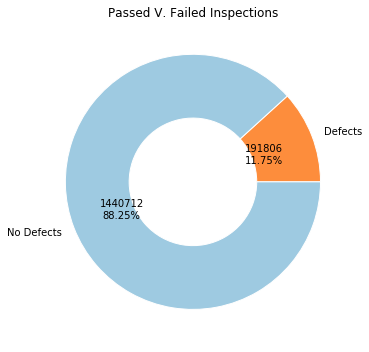

In [5]:
#pie charts
def pieChart(vals, labels, title):
    # just for visualization purposes
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:d}\n{:.2f}%".format(absolute, pct)
    
    fig = plt.figure(figsize=(5,5))
    size = 0.5
    ax = plt.subplot(111)
    size = 0.5
    cmap = plt.get_cmap("tab20c")
    inner_colors = cmap(np.array([5,2]))    
    ax.pie(vals, radius=1, colors=inner_colors,
           wedgeprops=dict(width=size, edgecolor='w'), autopct=lambda pct: func(pct,vals), labels=labels)
    ax.set(aspect="equal", title=title)
    plt.tight_layout()
    plt.show()
    
vals = np.array([defects.shape[0], no_defects.shape[0]])
labels = ['Defects', 'No Defects']
title = 'Passed V. Failed Inspections'
pieChart(vals, labels, title)

### Were there any trends in total inspections or defects?

In [7]:
yearly_counts = dbn.groupby('inspection_year')['boiler_id'].count()
yearly_defects = defects.groupby('inspection_year')['boiler_id'].count()

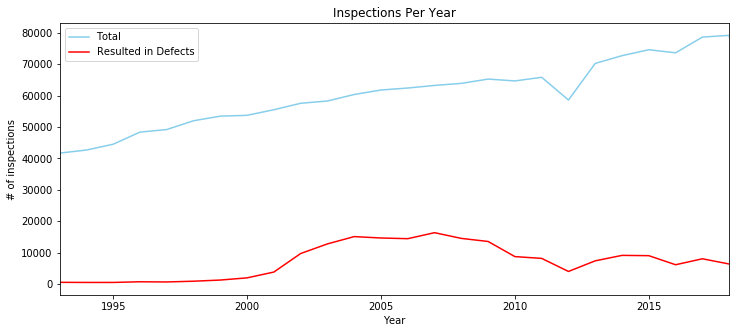

In [8]:
plt.figure(figsize=(12,5))
plt.title('Inspections Per Year')
plt.xlim(1993,2018)

plt.plot(yearly_counts.index, yearly_counts.values, color='skyblue', label='Total')
plt.plot(yearly_defects.index, yearly_defects.values, color='r', label='Resulted in Defects')

plt.xlabel("Year")
plt.ylabel('# of inspections')
plt.legend(loc=0)
plt.show()

### Average year of boiler (for defective boilers)

In [9]:
age_mean = defects.boiler_age.mean()

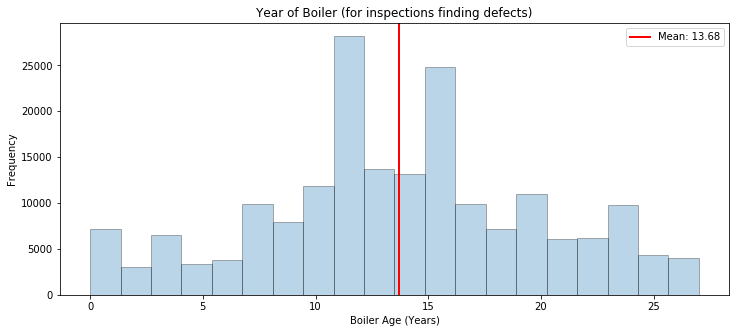

In [145]:
plt.figure(figsize=(12,5))
plt.title('Year of Boiler (for inspections finding defects)')
plt.xlabel('Boiler Age (Years)')
plt.ylabel('Frequency')

plt.hist(defects.boiler_age, bins=20, edgecolor='k', alpha=0.3)
plt.axvline(age_mean, c='r', lw=2, label='Mean: {:.2f}'.format(age_mean))
plt.legend()
plt.show()

# Main Question: What census tracts are outliers? 

### 1. What census tracts had the highest amount of boiler defects?

In [11]:
def CountRateFunc(field):
    gb_defects = defects.groupby(field)['bin_number'].count().reset_index()
    gb_all = dbn.groupby(field)['bin_number'].count().reset_index()
    summary = gb_defects.merge(gb_all, on=field)
    summary = summary.rename(columns={'bin_number_x':'CountFailed', 'bin_number_y':'CountTotal'})
    summary['FailureRate'] = (summary.CountFailed/summary.CountTotal)*100
    summary = summary.sort_values(by='FailureRate',ascending=False).reset_index(drop=True)
    return summary

In [12]:
summary = CountRateFunc('ct_bc_comb')
summary[summary.CountTotal > 200].head()

ct_bc_comb  CountFailed  CountTotal  FailureRate
5      3036100          391        1050    37.238095
7      2036502          114         312    36.538462
9      3053900           77         228    33.771930
10     4020800          163         485    33.608247
13    30116000          102         309    33.009709

### 2. Where are those census tracts? (Map)

In [13]:
censustracts = gpd.GeoDataFrame.from_file('data/2010 Census Tracts/geo_export_a333ab22-f2d4-4592-b15a-6ec4d68bc9ce.shp')

In [14]:
#format census tract ID to 6 characters
def replaceSuffix(x):
    val = len(x)
    # now if still not length of 4, add zeroes to beginning (300 -> 0300)
    if val<7:
        x = x[:1]+'0'+x[1:]
    return x

In [15]:
# fix census tract field
summary.ct_bc_comb = summary.ct_bc_comb.astype(str)
summary['ct_bc_comb'] = summary.ct_bc_comb.apply(replaceSuffix)
summary.head()

ct_bc_comb  CountFailed  CountTotal  FailureRate
0    1000500            4           6    66.666667
1    5027301           38          78    48.717949
2    5012805           10          25    40.000000
3    4050201            7          18    38.888889
4    3008500           24          63    38.095238

In [16]:
mean_count = summary.describe().CountTotal[1]
summary.describe()

CountFailed   CountTotal  FailureRate
count  2058.000000  2058.000000  2058.000000
mean     93.200194   792.677357    11.983686
std      96.329203   808.185625     5.162895
min       1.000000     6.000000     0.487805
25%      26.000000   251.000000     8.825284
50%      65.000000   559.000000    11.468028
75%     125.000000  1025.000000    14.461538
max     805.000000  6715.000000    66.666667

In [17]:
censustracts = censustracts.merge(summary, left_on='boro_ct201', right_on='ct_bc_comb')
censustracts.head(3)

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          I  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010000      Manhattan          I  010000     100    MN19   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.199811   
2                    Turtle Bay-East Midtown  3808  1.860938e+06  5692.168737   

                                            geometry ct_bc_comb  CountFailed  \
0  POLYGON ((-74.07920577013245 40.64343078374567...    5000900           23   
1  POLYGON ((-73.96432543478758 40.75638153099091...    1009800          475   
2  POLYGON ((-73.96802436915851 40.75957814005282...    1010000           85   

   CountTotal  FailureRate  
0         334     6.886228  
1        3113    15.258593  
2         803    10.585305

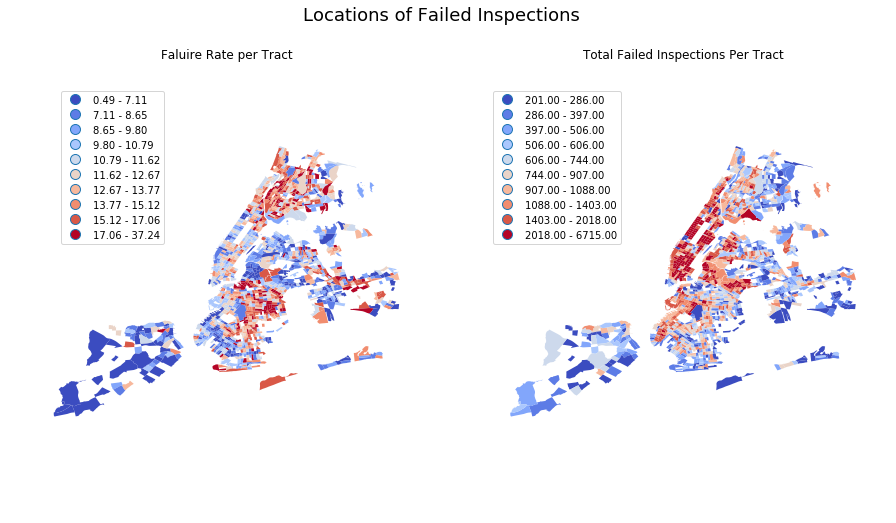

In [147]:
#visualize routes and hospital locations
fig = plt.figure(figsize=(15,8))
plt.suptitle('Locations of Defective Boilers', fontsize=18)

ax = plt.subplot(121)
censustracts[censustracts.CountTotal > 200].plot(ax=ax, column='FailureRate', cmap='coolwarm', scheme='Quantiles', k=10, legend=True)
    ax.set_title('Faluire Rate per Tract')
ax.axis('equal')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

ax2 = plt.subplot(122)
censustracts[censustracts.CountTotal > 200].plot(ax=ax2, column='CountTotal', cmap='coolwarm', scheme='Quantiles', k=10, legend=True)
ax2.set_title('Total Failed Inspections Per Tract')
ax2.axis('equal')
leg = ax2.get_legend()
leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

ax.axis('off')
ax2.axis('off')
plt.legend(loc=1)
# plt.tight_layout()

Figure: Here i limited the maps to census tracts who had *at least 10 total incidents*. I think from this point we can start to see which census tracts are outliers.

In [19]:
# what is a bad defect rate? 
sum_table = censustracts[censustracts.CountTotal > 200].describe()[['CountTotal','FailureRate']]
sum_table

CountTotal  FailureRate
count  1531.000000  1531.000000
mean    997.109732    12.029844
std     834.737907     4.272902
min     201.000000     0.487805
25%     447.000000     9.181761
50%     744.000000    11.618590
75%    1210.500000    14.372173
max    6715.000000    37.238095

In [20]:
# outlier is 3 standard deviations above the mean, results in 10 census tracts
threshold = (3*sum_table.FailureRate[2])+sum_table.FailureRate[1]

focustracts = censustracts[(censustracts.CountTotal > 500)&(censustracts.FailureRate > threshold)].boro_ct201
focustracts

131     3041700
177     3053300
297     2017500
756     3025100
771     3035700
1084    3036100
1328    2005001
1488    2024501
1568    3054700
1808    2004300
Name: boro_ct201, dtype: object

In [21]:
# clean version of ACS data
acs = pd.read_csv('data/ACS_for_joining.csv')
acs.drop('Unnamed: 0', axis=1, inplace=True)

# fix 'ct_bc_comb' for joining
acs.ct_bc_comb = acs.ct_bc_comb.astype(str)
acs['ct_bc_comb'] = acs.ct_bc_comb.apply(replaceSuffix)

# add in defect rate and total counts
acs = acs.merge(summary, on='ct_bc_comb')
acs.head()

over_65  total_population  white_population  median_household_income  \
0      786              5058              2665                  62773.0   
1      707              5944              2616                  82697.0   
2      748              6115              2685                  33118.0   
3       89              2817               519                  40117.0   
4     1021              9608              3344                  18370.0   

   state  county  tract  boro  over_65_pct  over_white_pct  tract2 ct_bc_comb  \
0     36       5    200     2     0.155397        0.526888     200    2000200   
1     36       5    400     2     0.118943        0.440108     400    2000400   
2     36       5   1600     2     0.122322        0.439084    1600    2001600   
3     36       5   1900     2     0.031594        0.184239    1900    2001900   
4     36       5   2000     2     0.106266        0.348043    2000    2002000   

   CountFailed  CountTotal  FailureRate  
0           10          79    12.658228  
1           11         172     6.395349  
2           73         842     8.669834  
3          137        1398     9.799714  
4          100         579    17.271157

In [22]:
# normalize continuous fields
dem_columns = ['over_65', 'total_population', 'white_population',
       'median_household_income', 'over_65_pct', 'over_white_pct']
inspection_columns = ['CountFailed', 'CountTotal', 'FailureRate']

acs_normed = acs.copy()
for field in dem_columns:
    acs_normed[field] = (acs_normed[field]-acs_normed[field].mean())/acs_normed[field].std()

acs_normed[acs_normed.ct_bc_comb.apply(lambda x: x in focustracts.values)].describe()\
        [dem_columns+inspection_columns]

over_65  total_population  white_population  median_household_income  \
count  10.000000         10.000000         10.000000                10.000000   
mean   -0.064174          0.336694         -0.156677                -1.121216   
std     0.523246          0.756971          1.323604                 0.160594   
min    -0.789070         -0.728308         -1.011551                -1.399338   
25%    -0.229858         -0.336869         -0.792022                -1.207989   
50%    -0.160109          0.427178         -0.718437                -1.134217   
75%     0.024052          0.893834         -0.502895                -1.008002   
max     1.034183          1.385824          3.090199                -0.859861   

       over_65_pct  over_white_pct  CountFailed   CountTotal  FailureRate  
count    10.000000       10.000000    10.000000    10.000000    10.000000  
mean     -0.403013       -0.539289   288.400000  1011.000000    28.641182  
std       0.463887        1.143287   125.565565   447.176326     3.491294  
min      -1.205415       -1.348117   152.000000   562.000000    25.509642  
25%      -0.683181       -1.208269   184.500000   624.000000    26.778489  
50%      -0.518249       -1.066757   260.500000   944.500000    27.228181  
75%       0.012762       -0.579547   375.500000  1170.750000    29.006301  
max       0.240299        1.876384   491.000000  1815.000000    37.238095

**Description**: According to the way I defined an outlier (3 std devs above mean for defect rate), this table lets us determine how the demographic variables compare to the rest of the dataset. 
* The most useful row is the mean, where the values are averages over the standardized demographic variables of each tract. 
    * Therefore, the most anomalous features look like they're the 'median_household_income' & 'over_white_pct' at 1.2 and 0.53 standard devs below the mean, respectively
* The average defect rate for our top 10 tracts is 28.6% with a standard deviation of 3.49%. 

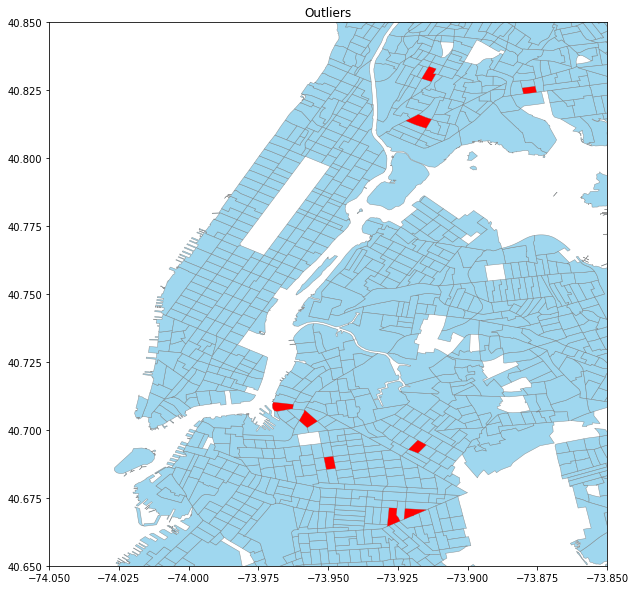

In [23]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(111)
ax.set_ylim(40.65,40.85)
ax.set_xlim(-74.05, -73.85)
censustracts.plot(ax=ax, color='skyblue', zorder=0, alpha=0.8, lw=0.5, edgecolor='grey')
censustracts[censustracts.ct_bc_comb.apply(lambda x: x in focustracts.values)].plot(ax=ax, color='r', 
                                                                                    zorder=1, label='Outlier')
ax.legend()

ax.set_title('Outliers')
# ax.axis('equal')
# ax.axis('off')

plt.legend(loc=5)

# Alternate Questions

### What owners had the greatest amount of failed tests?

In [24]:
owners = CountRateFunc('ownername')
owners[owners.CountTotal > 200].head()

# defects.groupby('OwnerName')['Boiler ID'].count().reset_index()\
#         .sort_values(by='Boiler ID', ascending=False).head(15)

ownername  CountFailed  CountTotal  FailureRate
2662  NEW YORK CITY HSG AUT          177         475    37.263158
2775  UNITED TALMUDICAL ACA          158         431    36.658933
2880  SUTTER HOUSING ASSOCI           94         260    36.153846
2996  CDC EAST 105TH STREET           80         223    35.874439
3118   LA CASA NUESTRA HDFC          125         356    35.112360

### What model types failed the most?

In [25]:
models = CountRateFunc(['boiler_make', 'boiler_model'])
models[models.CountTotal > 200].head()

# defects.groupby(['Boiler Make','Boiler Model'])['Boiler ID'].count().reset_index()\
#         .sort_values(by='Boiler ID', ascending=False).head(15)

boiler_make boiler_model  CountFailed  CountTotal  FailureRate
166       BRYAN        CL240          145         242    59.917355
243  HYDROTHERM       MR1800          129         238    54.201681
664    AO SMITH        HW200          342         833    41.056423
761  HYDROTHERM        MR360          322         809    39.802225
762    AO SMITH        HW670           95         240    39.583333

### What are the most failed property types?

In [26]:
# source: https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html
bldg_codes = pd.read_csv('data/bldgcodes.csv')
bldg_codes.head()

Code                           Description
0   A0                              CAPE COD
1   A1      TWO STORIES - DETACHED SM OR MID
2   A2  ONE STORY - PERMANENT LIVING QUARTER
3   A3              LARGE SUBURBAN RESIDENCE
4   A4             CITY RESIDENCE ONE FAMILY

In [27]:
bldg_class = CountRateFunc(['bldgclass'])
bldg_class = bldg_class.merge(bldg_codes, left_on='bldgclass', right_on='Code')
bldg_class.drop('Code', axis=1, inplace=True)
bldg_class[bldg_class.CountTotal > 290].head(10)

# defects.groupby(['bldgclass'])['Boiler ID'].count().reset_index()\
#         .sort_values(by='Boiler ID', ascending=False).head(15)

bldgclass  CountFailed  CountTotal  FailureRate  \
8         HH           63         319    19.749216   
10        J5           68         372    18.279570   
11        W5          125         736    16.983696   
13        V0           79         474    16.666667   
14        C9         1360        8384    16.221374   
16        H4          149         954    15.618449   
17        D3         4760       30792    15.458561   
18        L8          499        3239    15.405990   
20        W9          522        3478    15.008626   
22        D1        15589      107233    14.537502   

                                          Description  
8   HOSTELS- BED RENTALS IN DORMITORY-LIKE SETTING...  
10                      THEATRE IN MIXED-USE BUILDING  
11                                    CITY UNIVERSITY  
13                   ZONED RESIDENTIAL; NOT MANHATTAN  
14                                  GARDEN APARTMENTS  
16                                              MOTEL  
17             ELEVATOR APT; FIREPROOF WITHOUT STORES  
18       LOFT; WITH RETAIL STORES OTHER THAN TYPE ONE  
20                 MISCELLANEOUS EDUCATIONAL FACILITY  
22        ELEVATOR APT; SEMI-FIREPROOF WITHOUT STORES

schools & offices are real bad

### How does the age of buildings compare?

In [28]:
print(defects.describe().yearbuilt, '\n\n', no_defects.describe().yearbuilt)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    191806.000000
mean       1925.547652
std          94.555446
min           0.000000
25%        1915.000000
50%        1928.000000
75%        1932.000000
max        2018.000000
Name: yearbuilt, dtype: float64 

 count    1.440712e+06
mean     1.922413e+03
std      1.262340e+02
min      0.000000e+00
25%      1.916000e+03
50%      1.928000e+03
75%      1.931000e+03
max      2.018000e+03
Name: yearbuilt, dtype: float64


**Sam's questions:**
* Do defect rates differ for white vs non-white residents? What about older vs younger residents? Low-income vs high-income? (I guess we would need to filter down to residential or mixed-use properties only for this one)
* Do residential properties have higher defect rates than commercial properties? Or vice versa? Or no significant difference between the two?

In [29]:
# get residential buildings?
res = ['A','B','C','D','L','R']
# dbn[dbn.bldgclass.apply(lambda x: any(a in x for a in res))].shape, dbn.shape
print('\n{:.2f}% Residential'.format((dbn[dbn.bldgclass.apply(lambda x: any(a in x for a in res))].shape[0]/dbn.shape[0])*100))


64.20% Residential


In [30]:
def CountResidential(field):
    gb_defects = defects[defects.bldgclass.apply(lambda x: any(a in x for a in res))].groupby(field)['bin_number'].count().reset_index()
    gb_all = dbn[dbn.bldgclass.apply(lambda x: any(a in x for a in res))].groupby(field)['bin_number'].count().reset_index()
    summary = gb_defects.merge(gb_all, on=field)
    summary = summary.rename(columns={'bin_number_x':'CountFailed', 'bin_number_y':'CountTotal'})
    summary['FailureRate'] = (summary.CountFailed/summary.CountTotal)*100
    summary = summary.sort_values(by='FailureRate',ascending=False).reset_index(drop=True)
    return summary

In [31]:
acs.head()

over_65  total_population  white_population  median_household_income  \
0      786              5058              2665                  62773.0   
1      707              5944              2616                  82697.0   
2      748              6115              2685                  33118.0   
3       89              2817               519                  40117.0   
4     1021              9608              3344                  18370.0   

   state  county  tract  boro  over_65_pct  over_white_pct  tract2 ct_bc_comb  \
0     36       5    200     2     0.155397        0.526888     200    2000200   
1     36       5    400     2     0.118943        0.440108     400    2000400   
2     36       5   1600     2     0.122322        0.439084    1600    2001600   
3     36       5   1900     2     0.031594        0.184239    1900    2001900   
4     36       5   2000     2     0.106266        0.348043    2000    2002000   

   CountFailed  CountTotal  FailureRate  
0           10          79    12.658228  
1           11         172     6.395349  
2           73         842     8.669834  
3          137        1398     9.799714  
4          100         579    17.271157

In [32]:
sam_fields=['over_65_pct', 'over_white_pct', 'median_household_income','ct_bc_comb']

residential_counts = CountResidential('ct_bc_comb')
residential_counts.ct_bc_comb = residential_counts.ct_bc_comb.astype(str)
residential_counts['ct_bc_comb'] = residential_counts.ct_bc_comb.apply(replaceSuffix)
residential_counts = residential_counts.merge(acs[sam_fields], on='ct_bc_comb')
residential_counts.head()

ct_bc_comb  CountFailed  CountTotal  FailureRate  over_65_pct  \
0    4052000           13          15    86.666667     0.161211   
1    2036400            8          13    61.538462     0.137429   
2    3064400           13          22    59.090909     0.095380   
3    5023900            9          16    56.250000     0.076309   
4    4094202           12          23    52.173913     0.072558   

   over_white_pct  median_household_income  
0        0.016059                  69350.0  
1        0.002021                  64167.0  
2        0.739934                  88750.0  
3        0.551240                  65345.0  
4        0.328785                  48047.0

Text(0,0.5,'Over White (percentage)')

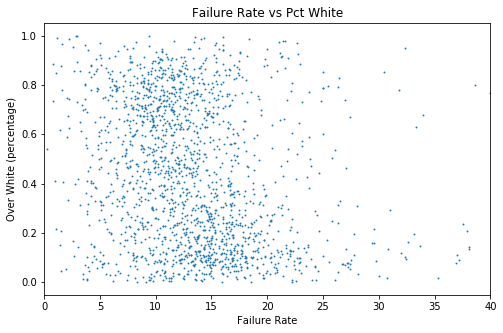

In [33]:
plt.figure(figsize=(8,5))
plt.title('Defect Rate vs Pct White')
plt.xlim(0,40)
plt.scatter(residential_counts.FailureRate, residential_counts.over_white_pct, s=0.8)
plt.xlabel('Defect Rate')
plt.ylabel('Over White (percentage)')

Text(0,0.5,'Over 65 yo (percentage)')

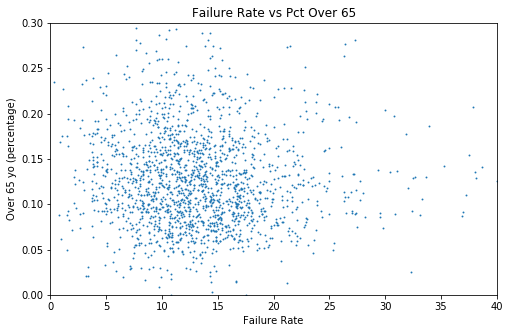

In [34]:
plt.figure(figsize=(8,5))
plt.title('Defect Rate vs Pct Over 65')
plt.xlim(0,40)
plt.ylim(0,0.3)
plt.scatter(residential_counts.FailureRate, residential_counts.over_65_pct, s=0.8)
plt.xlabel('Defect Rate')
plt.ylabel('Over 65 yo (percentage)')

Text(0,0.5,'Median Income')

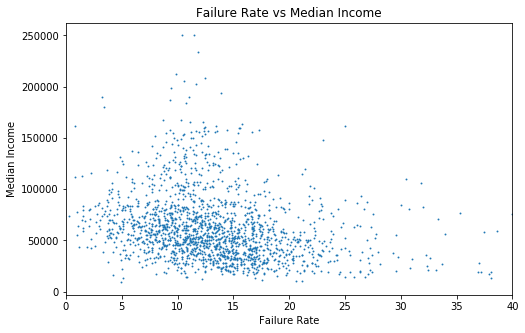

In [35]:
plt.figure(figsize=(8,5))
plt.title('Defect Rate vs Median Income')
plt.xlim(0,40)
# plt.ylim(0,0.4)
plt.scatter(residential_counts.FailureRate, residential_counts.median_household_income, s=0.8)
plt.xlabel('Defect Rate')
plt.ylabel('Median Income')

### How do previous defects impact the likelihood of finding defects in the future?

In [36]:
dbn = pd.read_csv('data/dbn_for_models.csv')

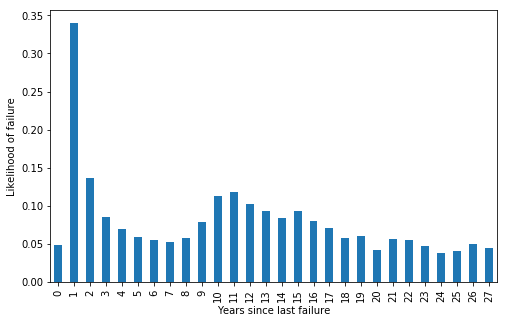

In [37]:
plt.figure(figsize=(8,5))
dbn.groupby('years_since_last_defects')['defects_exist'].mean().plot.bar()
plt.xlabel('Years since last defect found')
plt.ylabel('Likelihood of defect')
plt.show()

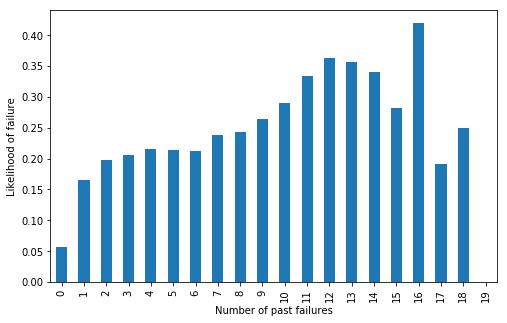

In [38]:
plt.figure(figsize=(8,5))
dbn.groupby('defects_history')['defects_exist'].mean().plot.bar()
plt.xlabel('Number of past defects')
plt.ylabel('Likelihood of defect')
plt.show()

### Defect rates by land use

In [55]:
# dbn = pd.read_csv('data/dbncats_ppacs.csv')
land_use = pd.read_csv('data/all_boilder_year_data_w_ACS.csv')
land_use.drop('Unnamed: 0', axis=1, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,20,30,33,35,36,37,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
# Get defect rates by land use type
lu_defects = pd.DataFrame(land_use.groupby('landuse')['defects_exist'].sum()/land_use.groupby\
                          ('landuse')['defects_exist'].count())
lu_defects.reset_index(inplace=True)
lu_defects

landuse  defects_exist
0       1.0       0.109896
1       2.0       0.115864
2       3.0       0.140404
3       4.0       0.116379
4       5.0       0.109967
5       6.0       0.107510
6       7.0       0.052404
7       8.0       0.102560
8       9.0       0.104429
9      10.0       0.056415
10     11.0       0.114574

In [121]:
land_use_names = {1: '1 & 2 Fam Bldg',
                  2: 'Multi-Fam Walk-Up Bldg',
                  3: 'Multi-Fam Elevator Bldg',
                  4: 'Mixed Res & Comm Bldg',
                  5: 'Comm & Office Bldg',
                  6: 'Industrial & Manu',
                  7: 'Transportation & Utility',
                  8: 'Public Facilities & Institutions',
                  9: 'Open Space & Outdoor Recreation',
                  10: 'Parking Facilities',
                  11: 'Vacant Land'}

In [122]:
lu_names_df = pd.DataFrame(land_use_names, index=[0]).T.rename(columns={0:'type_name'})
lu_names_df

type_name
1                     1 & 2 Fam Bldg
2             Multi-Fam Walk-Up Bldg
3            Multi-Fam Elevator Bldg
4              Mixed Res & Comm Bldg
5                 Comm & Office Bldg
6                  Industrial & Manu
7           Transportation & Utility
8   Public Facilities & Institutions
9    Open Space & Outdoor Recreation
10                Parking Facilities
11                       Vacant Land

In [123]:
lu_defects = lu_defects.merge(lu_names_df, how='left', left_on='landuse', right_index=True)
lu_defects

landuse  defects_exist                         type_name
0       1.0       0.109896                    1 & 2 Fam Bldg
1       2.0       0.115864            Multi-Fam Walk-Up Bldg
2       3.0       0.140404           Multi-Fam Elevator Bldg
3       4.0       0.116379             Mixed Res & Comm Bldg
4       5.0       0.109967                Comm & Office Bldg
5       6.0       0.107510                 Industrial & Manu
6       7.0       0.052404          Transportation & Utility
7       8.0       0.102560  Public Facilities & Institutions
8       9.0       0.104429   Open Space & Outdoor Recreation
9      10.0       0.056415                Parking Facilities
10     11.0       0.114574                       Vacant Land

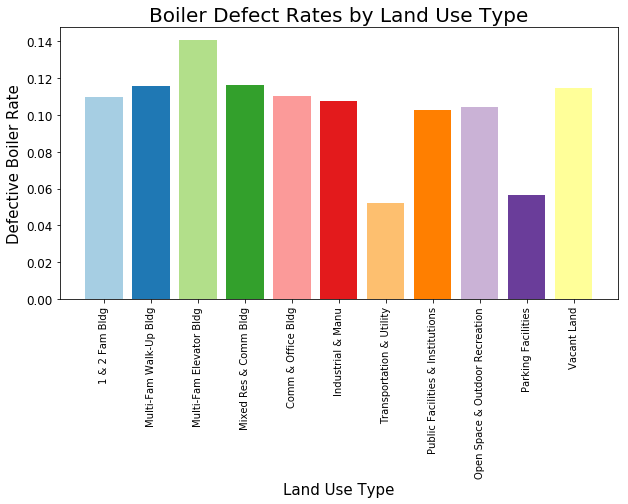

In [132]:
x = lu_defects.landuse
y = lu_defects.defects_exist
plt.figure(figsize=(10,5))
for i in range(0,len(x)):
    plt.bar(x[i],y[i], color=cm.Paired(1.*i/len(x)))

    
plt.title("Boiler Defect Rates by Land Use Type", fontsize=20)
plt.xlabel("Land Use Type", fontsize=15)
plt.ylabel("Defective Boiler Rate", fontsize=15)
plt.xticks(x, lu_defects.type_name, rotation='vertical', fontsize=10)
plt.yticks(fontsize=12)
plt.show()